### Primery processing of tarean reports
###### *Gurina Alena*

Download libraries

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Make list with all folders, where are tarean reports we need for analisis <br>
And using os package, for each directory walking throught and collecting data about all files in each directory

In [2]:
species = ['Phureja', 'Stenotomum', 'Goniocalyx', 'Ajanhuiri']
list_files = []
for spec in species:
    a_generator = os.walk(spec)
    for direct in a_generator:
        list_files.append(direct)

getting dataframe from tarean csv reports
<ol>
    <li> create empty dataframe</li>
    <li> write name of column we need (because tarean report is too big)</li>
    <li> part of tarean report called .cluster_info.csv, we use these part of report because it more convinient for handle (there is an example of tarean report file in folder `Tarean report example` </li>
    <li> for each directory find report file, read it, drop columns we don`t need and add it too common dataframe, also collect information about species, sample and number of program launch (shot) </li>
    <li> saving result because these step lasts quite long </li>

In [3]:
all_df = pd.DataFrame()
df_need = {'index', 'size', 'satellite_probability', 'TR_monomer_length', 'TR_consensus', 'image_file', 
           'html_tarean', 'loop_index', 'pair_completeness', 'TR_score', 'vcount', 'ecount', 'pbs_score', 
           'annotations_table', 'putative_tandem', 'satellite', 'tarean_contig_file', 'ltr_detection', 'tandem_rank'}
for el in list_files:
    if '.clusters_info.csv' in el[2]:
        name = el[0].split('/')[-1].split('_')
        df_name = "./" + el[0] + "/" + '.clusters_info.csv'
        df_1 = pd.read_csv(df_name, sep = "\t")
        df_all_names = set(df_1.columns)
        df_no_need = df_all_names - df_need
        df_cut = df_1.drop(df_no_need, axis = 1)
        df_cut['species'] = name[0][0:2]
        df_cut['sample'] = name[0]
        df_cut['shot'] = name[1]
        all_df = all_df.append(df_cut, sort = False, ignore_index = True)
#saving results
#all_df.to_csv("all_clusters.csv")

I collect information from different specisies separatly, so next rows are useful if you need to combine undependantly collected tarean results

In [4]:
df1 = pd.read_csv('sten_phu.csv')
df2 = pd.read_csv('aj_gon.csv')
all_df = df1.append(df2, ignore_index = True, sort = True)
species = []
for el in all_df['sample']:
    species.append(el[0:2])
all_df['species'] = species

At with step we could collect information about some summary statistics like how many of each repeats type we get

In [5]:
sum_x = pd.DataFrame(all_df.groupby(['species','tandem_rank'])['size'].count())

In [6]:
tand_df = all_df.drop(all_df[(all_df['TR_consensus'] == 'None')].index)

to compare distribution of repetitive elements in different species, count mean number of repeats <br>
*Dividing number - it is number of launch programm we have done for each species*

In [7]:
sum_tandems = pd.DataFrame(tand_df.groupby(['species','tandem_rank'])['size'].count())
sum_tandems.reset_index(inplace = True)
repeats_for_one_sample = []
for i in range(0, len(sum_tandems)):
    if sum_tandems.loc[i]['species'] == 'Aj':
        repeats_for_one_sample.append(sum_tandems.loc[i]['size']/5)
    elif sum_tandems.loc[i]['species'] == 'Go':
        repeats_for_one_sample.append(sum_tandems.loc[i]['size']/20)
    elif sum_tandems.loc[i]['species'] == 'Ph':
        repeats_for_one_sample.append(sum_tandems.loc[i]['size']/35)
    elif sum_tandems.loc[i]['species'] == 'St':
        repeats_for_one_sample.append(sum_tandems.loc[i]['size']/42)
    else:
        raise ValueError
sum_tandems["mean_repeats"] = repeats_for_one_sample

<Figure size 6000x4800 with 0 Axes>

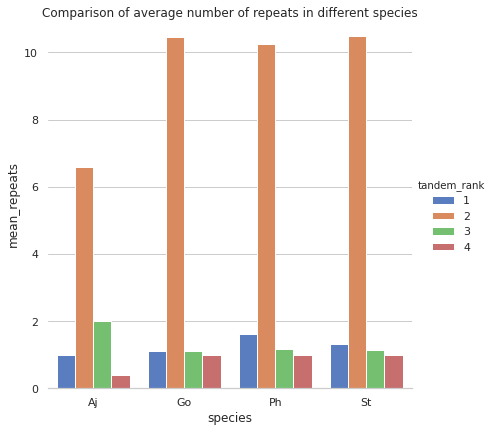

In [8]:
plt.figure(figsize = (15,12), dpi = 400)
sns.set(style="whitegrid")
g = sns.catplot(x="species", y="mean_repeats", hue = 'tandem_rank', data=sum_tandems,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
plt.title("Comparison of average number of repeats in different species", pad = 2)
plt.savefig("comparison_amount_repeats.png")

Next step is to compare sequences of different repetitive elements, but first we should preprocess it
First of all we need to delete prefix from it (in tarean report there is *<pre> before and after sequence, so we need to delete them

In [9]:
seq = []
for el in list(tand_df.TR_consensus):
    val = el.rstrip()[6:-5]
    seq.append(val)
tand_df['seq'] = seq
tand_df = tand_df.drop(['image_file', 'ltr_detection','putative_tandem', 'tarean_contig_file', 'TR_consensus', 'html_tarean', 'Unnamed: 0'], axis = 1)

Next we need to create uniq name for each sequence (It contain name of sample, name of shot and tarean cluster number
And then we write fasta file to futher analysis

In [10]:
cl_names = []
for i in range(0,  len(tand_df)):
    name = '>' + str(tand_df.iloc[i]['sample']) + str(tand_df.iloc[i]['shot']) + '_Cl' + str(tand_df.iloc[i]['index'])
    cl_names.append(name[1:])
    seq = str(tand_df.iloc[i]['seq'])
    with open ('sequences_repeats.fasta', 'a') as output:
        output.write(name + '\n')
        output.write(seq + '\n')
tand_df['cl_names'] = cl_names

Saving results for futher analysis

In [11]:
tand_df.to_csv("repeats_tandem.csv")